# The Rossiter-McLaughlin Effect

In [1]:
%matplotlib inline

In [210]:
import matplotlib.pyplot as plt
import numpy as np


# Speed of light in m/s
c = 3.00e8

In [352]:
import starry_beta as starry

def rv_field(x, y, z, veq=1, inc=90, obl=0, alpha=0):
    """Return the radial velocity at a point on the stellar surface."""
    cosi = np.cos(inc * np.pi / 180)
    sini = np.sin(inc * np.pi / 180)
    cosl = np.cos(obl * np.pi / 180)
    sinl = np.sin(obl * np.pi / 180)
    A = sini * cosl
    B = sini * sinl
    C = cosi
    return veq * (A * x + B * y) * (1 - alpha * (-B * x + A * y + C * z) ** 2)


def get_ylm_coeffs(veq=1, inc=90, obl=0, alpha=0):
    """Return the normalized spherical harmonic coefficients for the RV field of a star."""
    cosi = np.cos(inc * np.pi / 180)
    sini = np.sin(inc * np.pi / 180)
    cosl = np.cos(obl * np.pi / 180)
    sinl = np.sin(obl * np.pi / 180)
    A = sini * cosl
    B = sini * sinl
    C = cosi
    return np.array([0,
                     np.sqrt(3)*np.pi*B*(-A**2*alpha - B**2*alpha - C**2*alpha + 5)/15,
                     0,
                     np.sqrt(3)*np.pi*A*(-A**2*alpha - B**2*alpha - C**2*alpha + 5)/15,
                     0,
                     0,
                     0,
                     0,
                     0,
                     np.sqrt(70)*np.pi*B*alpha*(3*A**2 - B**2)/70,
                     2*np.sqrt(105)*np.pi*C*alpha*(-A**2 + B**2)/105,
                     np.sqrt(42)*np.pi*B*alpha*(A**2 + B**2 - 4*C**2)/210,
                     0,
                     np.sqrt(42)*np.pi*A*alpha*(A**2 + B**2 - 4*C**2)/210,
                     4*np.sqrt(105)*np.pi*A*B*C*alpha/105,
                     np.sqrt(70)*np.pi*A*alpha*(A**2 - 3*B**2)/70]) * (veq / np.pi)


def get_rm_rv(v_eq, xo, yo, ro):
    """
    
    """
    map_Iv_plus_I = starry.Map(3)
    map_Iv_plus_I[:3, :] = get_ylm_coeffs(veq=v_eq)
    map_Iv_plus_I[:3, :] = get_ylm_coeffs(veq=v_eq)
    map_Iv_plus_I[0, 0] = 1
    map_I = starry.Map(0)
    map_I[0, 0] = 1
    Iv_plus_I = map_Iv_plus_I.flux(xo=xo, yo=yo, ro=ro)
    I = map_I.flux(xo=xo, yo=yo, ro=ro)
    return (Iv_plus_I - I) / I

In [272]:
def get_s(xo, yo, ro):
    """
    Many hacks here.
    
    """
    map = starry.Map(1)
    map[:, :] = 1
    s0 = np.zeros(Nt)
    s1 = np.zeros(Nt)
    for i in range(len(xo)):
        if (xo[i] ** 2 + yo[i] ** 2) >= (1 + ro) ** 2:
            s0[i] = np.pi
            s1[i] = 0.0
        else:
            map.flux(xo=xo[i], yo=yo[i], ro=ro)
            s0[i] = map.s[0]
            s1[i] = 2 * map.s[3]
            if xo[i] < 0:
                s1[i] *= -1
    return s0, s1

In [533]:
# A spectrum evenly spaced in log(lambda)
Nxi = 1000
xi = np.linspace(-0.003, 0.003, Nxi)
dxi = xi[1] - xi[0]
lam = np.exp(xi)

# A gaussian absorption line and its Fourier transform
amp = 1.0
mu = 1.0
sigma = 0.0003
I0 = 1 - amp * np.exp(-0.5 * (lam - mu) ** 2 / sigma ** 2)
fI0 = np.fft.rfft(I0)
k = np.fft.rfftfreq(Nxi, dxi)

# We're observing a timeseries
Nt = 1000
t = np.linspace(0, 1, Nt)

# Define an occultor path and compute 
# the `s` vector with `starry`
xo = np.linspace(-2.25, 2.25, Nt)
yo = np.zeros(Nt)
ro = 0.1
s0, s1 = get_s(xo, yo, ro)

# Apply the velocity field. Assume v_eq = 300 km/s
v_eq = 300 * 1e3
beta_eq = v_eq / c
fS = fI0 * (s0[:, None] - np.pi * 1j * k * beta_eq * s1[:, None])

# Take the inverse FFT
S = np.fft.irfft(fS, Nxi)

# Normalize by the continuum
S /= S[:, 0][:, None]

0.001


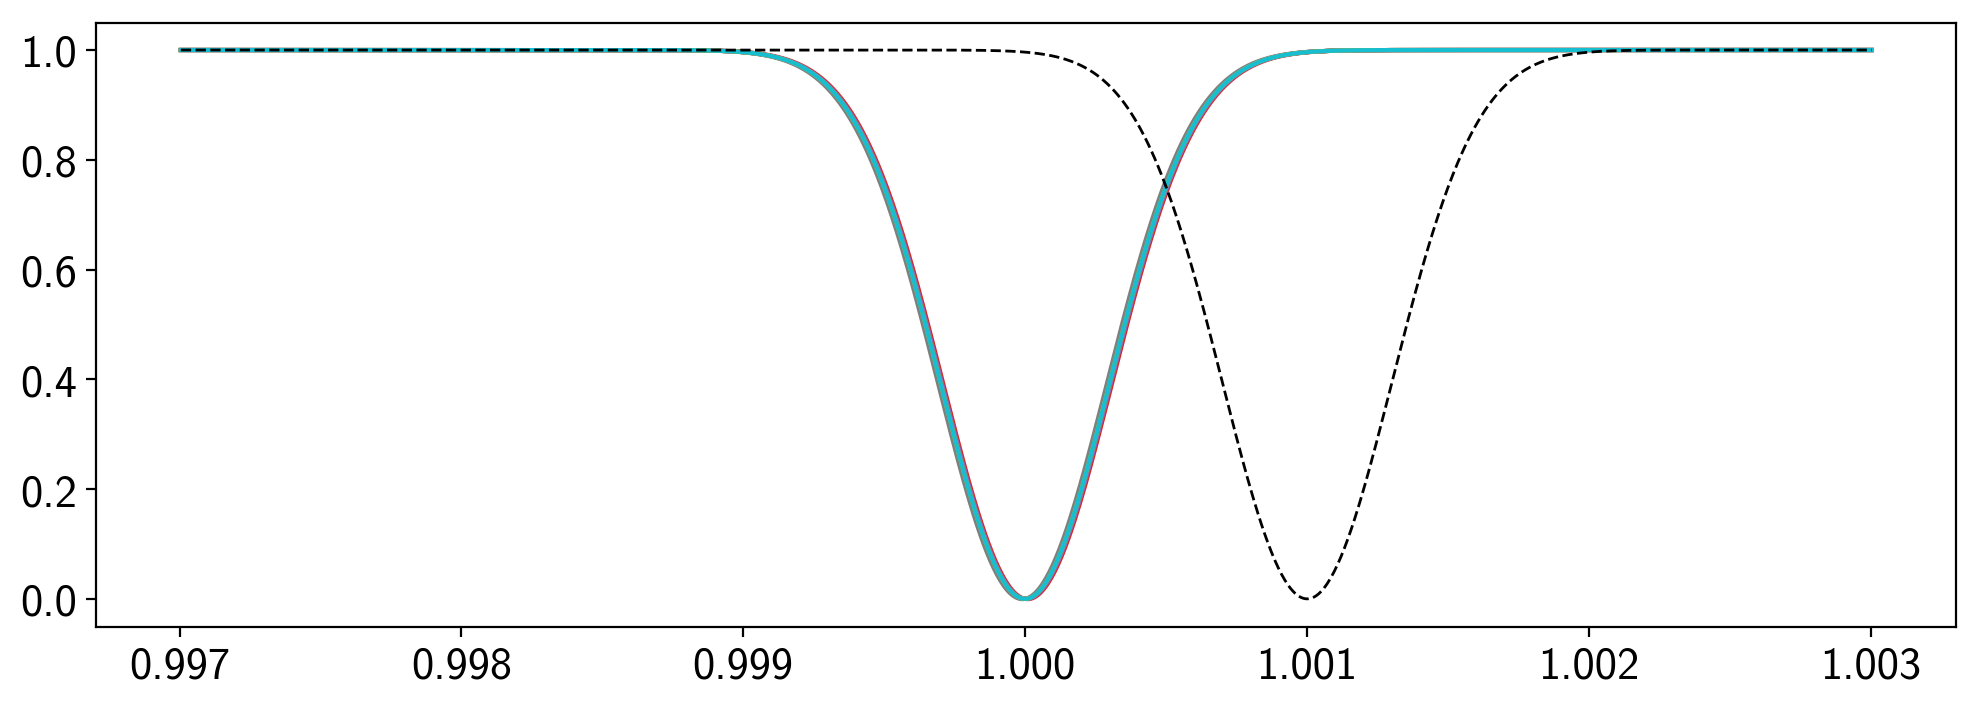

In [534]:
# Plot 10 spectra
print(beta_eq)
for S_t in S[::100]:
    plt.plot(lam, S_t)

# The expected magnitude of the shift
_fS = fI0 * np.exp(2 * np.pi * np.log(1 - beta_eq) * 1j * k)
_S = np.fft.irfft(_fS, Nxi)
plt.plot(lam, _S, 'k--', lw=1);

In [455]:
cc = np.array([np.correlate(S[i], S[0], mode="full") for i in range(Nt)])

In [456]:
# Let's use the method of Teague & Foreman-Mackey (2018)
# to find the maximum of the cross-correlation function
# as a function of time:
deltaxi = np.zeros(Nt)
for i in range(Nt):
    power = cc[i]
    imax = np.argmax(power)
    Ic = power[imax]
    Ip = power[imax + 1]
    Im = power[imax - 1]
    a0 = Ic
    a1 = 0.5 * (Ip - Im)
    a2 = 0.5 * (Ip + Im - 2 * Ic)
    deltaxi[i] = (-0.5 * a1 / a2) * dxi

In [457]:
# Let's convert delta lambda to a velocity
rv = (np.exp(deltaxi) - 1) * c

188.88193478213987


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


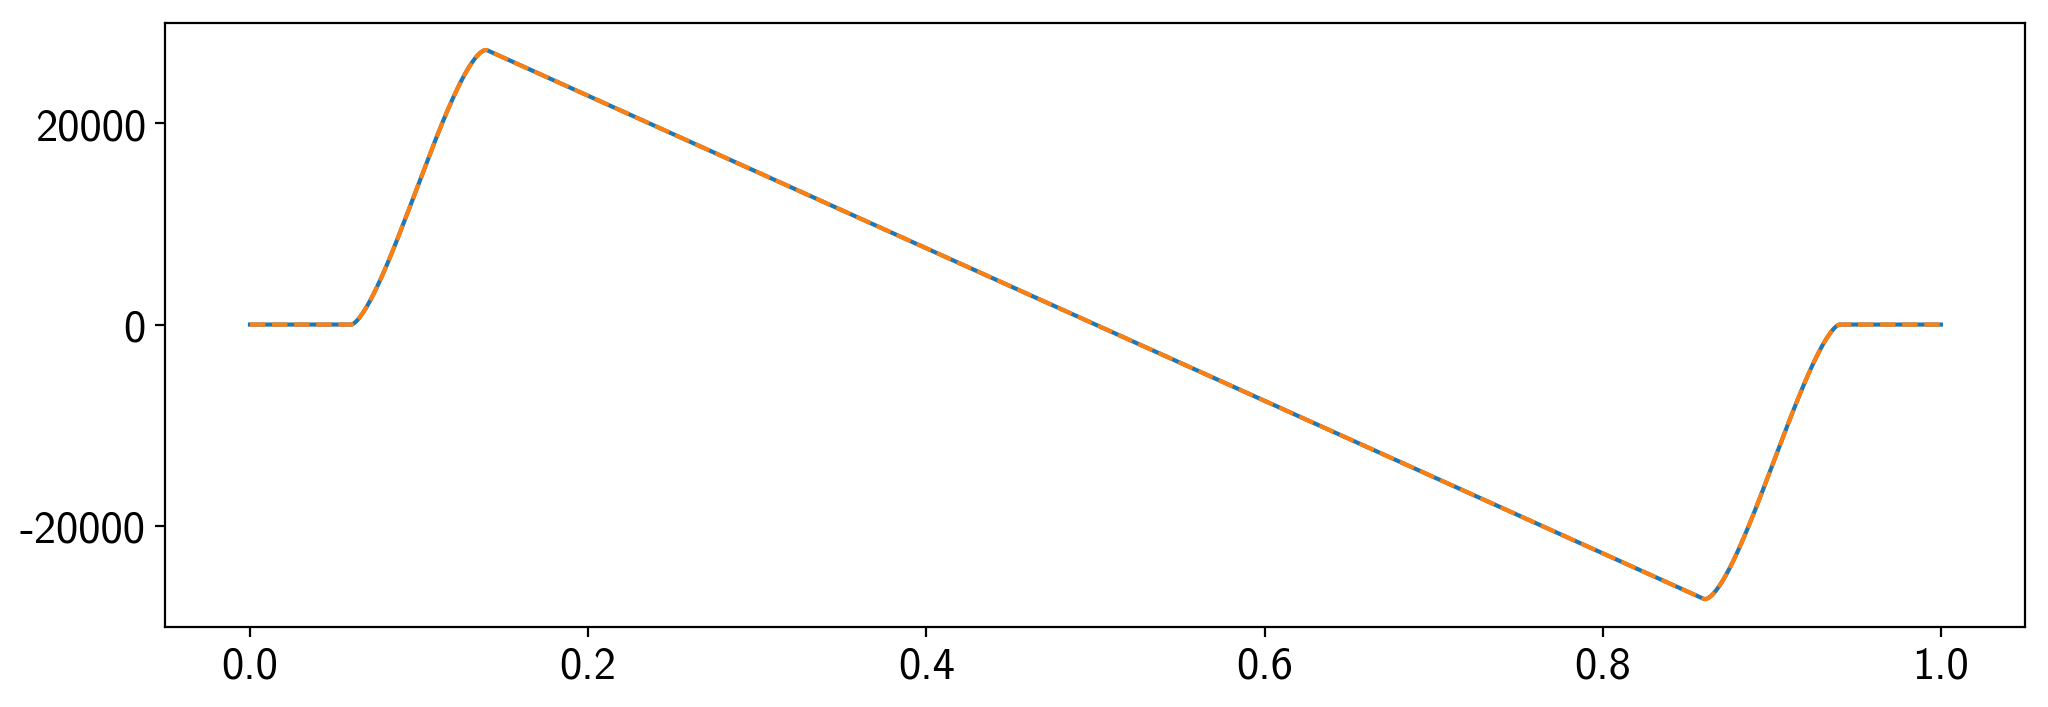

In [458]:
# Computed the usual way
rm = get_rm_rv(v_eq, xo, yo, ro)
plt.plot(t, rm)

# The Rossiter-McLaughlin effect
plt.plot(t, rv * 188.88, "C1--");

print(np.nanmedian(rm / rv))